In [1]:
#if using colab
#%tensorflow_version 1.x 


TensorFlow 1.x selected.


In [2]:

import tensorflow as tf
tf.__version__

'1.15.2'

In [3]:
import string
import json
from time import time
import pickle
from keras.models import Model, load_model
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Dense, Dropout, Embedding, LSTM
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np 
import os 
import pandas as pd 
import glob
import cv2

## Loading the data in desired form

In [ ]:
df=pd.read_csv("/content/drive/My Drive/results.csv",delimiter='|')

In [2]:
# store the index of images
f1 = open("train.txt","w")
for file in os.listdir("/content/drive/My Drive/image captioning/flickr30k_images"):
    if os.path.isfile(os.path.join("/content/drive/My Drive/image captioning/flickr30k_images", file)):
        path = file
    if file=='results.csv':
        continue
    f1.write("%s\n" %file[:-4])

f1.close()

In [ ]:
imgdir=glob.glob("/content/drive/My Drive/image captioning/flickr30k_images/"+"*.jpg")

In [10]:
imgdir[:5]

['/content/drive/My Drive/image captioning/flickr30k_images/836768303.jpg',
 '/content/drive/My Drive/image captioning/flickr30k_images/836828001.jpg',
 '/content/drive/My Drive/image captioning/flickr30k_images/837893113.jpg',
 '/content/drive/My Drive/image captioning/flickr30k_images/83755390.jpg',
 '/content/drive/My Drive/image captioning/flickr30k_images/837919879.jpg']

 Two young guys with shaggy hair look at their hands while hanging out in the yard .
(500, 333, 3)


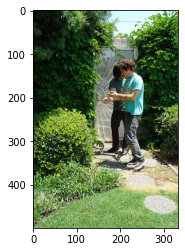

In [11]:
img=cv2.imread("/content/drive/My Drive/image captioning/flickr30k_images/"+df.image_name.iloc[0])
#print(img)
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)
print(df[' comment'].iloc[0])
print(img.shape)

In [12]:
df

,image_name,comment_number,comment
0,1000092795.jpg,0,Two young guys with shaggy hair look at their...
1,1000092795.jpg,1,"Two young , White males are outside near many..."
2,1000092795.jpg,2,Two men in green shirts are standing in a yard .
3,1000092795.jpg,3,A man in a blue shirt standing in a garden .
4,1000092795.jpg,4,Two friends enjoy time spent together .
...,...,...,...
158910,998845445.jpg,0,A man in shorts and a Hawaiian shirt leans ov...
158911,998845445.jpg,1,"A young man hanging over the side of a boat ,..."
158912,998845445.jpg,2,A man is leaning off of the side of a blue an...
158913,998845445.jpg,3,"A man riding a small boat in a harbor , with ..."


In [13]:
import os
ans=0
for file in os.listdir("/content/drive/My Drive/image captioning/flickr30k_images"):
    
    ans=ans+1
print(ans)

31709


In [14]:
df.image_name.unique().shape

(31783,)

In [ ]:
df=df.rename(columns={" comment" : "comment"})

In [ ]:
df.comment=df.comment.astype(str)

In [ ]:
def fun(df1):
    
    alist=list(df1['comment'].values)
    return alist

In [ ]:
df1=df.groupby('image_name').apply(fun)

In [ ]:
index=df1.index
values=df1.values

In [ ]:
index=np.array(index)
values=np.array(values)

In [ ]:
for i,j in enumerate(index):
    index[i]=j[:-4]
    #print(i,j)

In [ ]:
descriptions=dict([(index[i],values[i]) for i in range(len(values))])


In [ ]:
import re

In [ ]:
def clean_the_text(text):
    text=text.lower()
    text=re.sub(r"[^\w\d]"," ",text)
    text=re.sub(r"\s{2,}"," ",text)
    text=text.strip()
    text=text.split()
    text=[t for t in text if len(t)>1]
    text=" ".join(text)
    return text


In [25]:
clean_the_text(". hey 2.5 hoem")

'hey hoem'

In [ ]:
for key, desc_list in descriptions.items():
    for i in range(len(desc_list)):
        #print(type(desc_list[i]))
        desc_list[i] = clean_the_text(desc_list[i])

In [27]:
vocabulary = set()    # only contains the unique entries

for key in descriptions.keys():
    [vocabulary.update(i.split()) for i in descriptions[key]]

print('Vocabulary Size: %d' % len(vocabulary))

Vocabulary Size: 18252


In [28]:
# create vocabulary of all the words
complete_vocab =  []

for key in descriptions.keys():
    [complete_vocab.append(i) for des in descriptions[key] for i in des.split()]

print('Vocabulary Size: %d' % len(complete_vocab))
print(complete_vocab[:15])

Vocabulary Size: 1679691
['two', 'young', 'guys', 'with', 'shaggy', 'hair', 'look', 'at', 'their', 'hands', 'while', 'hanging', 'out', 'in', 'the']


In [1]:
now include only those words which are greater(in length) than a threshold value
import collections


counter= collections.Counter(complete_vocab)

dic_ = dict(counter)
print(dic_)
threshelod_value = 10

sorted_dic = sorted(dic_.items(), reverse=True, key = lambda x: x[1])
sorted_dic = [x for x in sorted_dic if x[1]>threshelod_value]
complete_vocab = [x[0] for x in sorted_dic]

In [ ]:
# laod images index for adding the start and end of the sequence
train = open("/content/train.txt").read().split('\n')[:-1]


In [ ]:
train_descriptions = {}

for t in train:
    train_descriptions[t] = []
    for cap in descriptions[t]:
        cap_to_append = "startseq " + cap + " endseq"
        train_descriptions[t].append(cap_to_append)

## Preprocessing the Captions

In [ ]:
# create a mapping of each word in complete_voclab to its index and do the vice versa

i = 1
word_to_idx = {}
idx_to_word = {}

for e in complete_vocab:
    word_to_idx[e] = i
    idx_to_word[i] = e
    i +=1

In [ ]:
# we will add the start and end as we haved appended the in our captions

word_to_idx['startseq'] = 1846
word_to_idx['endseq'] = 1847

idx_to_word[1846] = 'startseq'
idx_to_word[1847] = 'endseq'

In [34]:
vocab_size = len(idx_to_word)+1 # +1 beacuse we will add 0 to those places of caption which have nothing(as they are shorter than max len). Thus we need to include a idx_to_word[0]='0'
print(vocab_size)

5128


In [35]:
# find the max length of captions present in our dataset
all_captions_len = []

for key in train_descriptions.keys():
    for cap in train_descriptions[key]:
        all_captions_len.append(len(cap.split()))

max_len = max(all_captions_len)
print(max_len)

74


## Preprocess the Images

In [36]:
model=tf.keras.applications.resnet50.ResNet50(weights='imagenet',input_shape=(224,224,3))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
102973440/102967424 [==============================] - 1s 0us/step


In [3]:
# model.summary()

In [ ]:
model_new = tf.keras.Model(model.input, model.layers[-2].output)

In [ ]:
# specify the path of images
images="/content/drive/My Drive/image captioning/flickr30k_images"

In [ ]:
def preprocess_img(img):
    img=tf.keras.preprocessing.image.load_img(img,target_size=(224,224))
    img=tf.keras.preprocessing.image.img_to_array(img)
    img=np.expand_dims(img,axis=0)
    img=tf.keras.applications.resnet50.preprocess_input(img)
    return img

In [ ]:
def encode_image(img):
    img = preprocess_img(img)
    feature_vector = model_new.predict(img)
    feature_vector = feature_vector.reshape(feature_vector.shape[1],)
    return feature_vector

In [ ]:
#convert every image in the dataset to feature vector as abtained from the Resnet50
start = time()

encoding_train = {}

for ix, img_id in enumerate(train):
    
    img_path= images+"/"+img_id+".jpg"
    encoding_train[img_id] = encode_image(img_path)
  
    if ix%100==0:
        print("Encoding image- "+ str(ix))
    
print("Time taken in seconds =", time()-start)

In [ ]:
#save the train pickle
with open("/content/drive/My Drive/encoded_train_pickle1.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_train, encoded_pickle)

In [ ]:
#do same encoding on test images
test = open("./test.txt").read().split('\n')[:-1]

In [92]:
start = time()

encoding_test = {}

for ix, img_id in enumerate(test):

    img_path= images+"/"+img_id+".jpg"
    encoding_test[img_id] = encode_image(img_path)
    
    
    print("Encoding image- "+ str(ix))
    
print("Time taken in seconds =", time()-start)

Encoding image- 0
Encoding image- 1
Encoding image- 2
Encoding image- 3
Encoding image- 4
Time taken in seconds = 1.231635570526123


In [ ]:
#loading the train pickle
with open("/content/drive/My Drive/encoded_train_pickle1.pkl", "rb") as encoded_pickle:
    encoding_train = pickle.load(encoded_pickle)


In [ ]:
#save the test pickle
with open("./encoded_test_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_test, encoded_pickle)

In [ ]:
def data_generator(train_descriptions, encoding_train, word_to_idx, max_len, num_photos_per_batch):

    input_img= []
    input_sequence= []
    output_sequence = []

    n=0

    while True:
        
        for key, description_list in train_descriptions.items():
            n +=1

            photo = encoding_train[key]

            for desc in description_list:

                
                seq = [ word_to_idx[word] for word in desc.split() if word in word_to_idx]  

                for i in range(1,len(seq)):
                    

                    rnn_cell_input= seq[0:i]
                    rnn_cell_output = seq[i]

                    rnn_cell_input= pad_sequences([rnn_cell_input], maxlen=max_len, value=0, padding='post')[0]

                    rnn_cell_output = to_categorical([rnn_cell_output], num_classes=vocab_size)[0]

                    input_img.append(photo)
                    input_sequence.append(rnn_cell_input)
                    output_sequence.append(rnn_cell_output)

                if n==num_photos_per_batch:
                    yield [[np.array(input_img), np.array(input_sequence)], np.array(output_sequence)]
                    input_img= []
                    input_sequence= []
                    output_sequence = []
                    n=0

## Word Embedding

In [ ]:
# Download the GloVE

from google.colab import files
files.upload()  #this will prompt you to upload the kaggle.json
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json  # set permission
!kaggle datasets download -d watts2/glove6b50dtxt


In [ ]:
# extract the downloaded zip
import zipfile

In [48]:
zip=zipfile.ZipFile("/content/drive/My Drive/glove6b50dtxt.zip")
zip.extract("glove.6B.50d.txt")

'/content/glove.6B.50d.txt'

In [ ]:
f = open("/content/drive/My Drive/glove.6B.50d.txt", encoding='utf8')

In [ ]:
embedding_index = {}

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype="float")
    
    embedding_index[word] = coefs
    
f.close()

### Converting words into vectors Directly - (Embedding Layer Output)

In [ ]:

def get_embedding_output():
    
    emb_dim = 50
    embedding_output = np.zeros((vocab_size,emb_dim))
    
    for word, idx in word_to_idx.items():
        embedding_vector = embedding_index.get(word)
        
        if embedding_vector is not None:
            embedding_output[idx] = embedding_vector
            
    return embedding_output


embedding_output = get_embedding_output()

In [52]:
embedding_output.shape


(5128, 50)

## Model architecture

In [4]:
# image feature extracter model

input_img_fea = Input(shape=(2048,))
inp_img1 = Dropout(0.3)(input_img_fea)
inp_img2 = Dense(256, activation='relu')(inp_img1)

In [5]:
# partial caption sequence model

input_cap = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim=vocab_size, output_dim=50, mask_zero=True)(input_cap)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)

In [ ]:

decoder1 = add(([inp_img2 , inp_cap3]))
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

# Merge 2 networks
model = Model(inputs=[input_img_fea, input_cap], outputs=outputs)

In [6]:

model.layers[2].set_weights([embedding_output])
model.layers[2].trainable = False

In [7]:

model.compile(loss="categorical_crossentropy", optimizer="adam",metrics=["acc"])

In [58]:

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 74)           0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 74, 50)       256400      input_2[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           input_1[0][0]                    
____________________________________________________________________________________________

NOW, THE BOSS LEVEL

# LETS TRAIN !!!

In [ ]:
filepath = "/content/drive/My Drive/Checkpoint/model.h5"

In [ ]:
epochs = 20
number_pics_per_bath = 3
steps = len(train_descriptions)//number_pics_per_bath

In [ ]:
for i in range(epochs):
    generator = data_generator(train_descriptions, encoding_train, word_to_idx, max_len, number_pics_per_bath)
    
    checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
    callbacks_list = [checkpoint]


    # Train the model with the new callback
    model.fit_generator(
          generator, 
          epochs=1,
          steps_per_epoch=steps,
          callbacks=callbacks_list) 
model.save('/content/drive/My Drive/Checkpoint/model_final.h5')



Epoch 1/1
10569/10569 [==============================] - 2439s 231ms/step - loss: 4.2493 - acc: 0.2409

Epoch 00001: loss improved from inf to 4.27060, saving model to /content/drive/My Drive/Checkpoint/model.h5
Epoch 1/1
10569/10569 [==============================] - 2450s 232ms/step - loss: 3.7725 - acc: 0.2754

Epoch 00001: loss improved from inf to 3.78423, saving model to /content/drive/My Drive/Checkpoint/model.h5
Epoch 1/1
10569/10569 [==============================] - 2451s 232ms/step - loss: 3.6624 - acc: 0.2840

Epoch 00001: loss improved from inf to 3.67336, saving model to /content/drive/My Drive/Checkpoint/model.h5
Epoch 1/1
10569/10569 [==============================] - 2447s 232ms/step - loss: 3.6109 - acc: 0.2882

Epoch 00001: loss improved from inf to 3.62171, saving model to /content/drive/My Drive/Checkpoint/model.h5
Epoch 1/1
10569/10569 [==============================] - 2422s 229ms/step - loss: 3.5841 - acc: 0.2904

Epoch 00001: loss improved from inf to 3.59495

In [8]:
#continue from the last checkpoint
# new_model = load_model(filepath)

In [ ]:
for i in range(epochs):
    generator = data_generator(train_descriptions, encoding_train, word_to_idx, max_len, number_pics_per_bath)
    filepath = "/content/drive/My Drive/Checkpoint/model.h5"
    checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
    callbacks_list = [checkpoint]


    # Train the model with the new callback
    new_model.fit_generator(
          generator, 
          epochs=1,
          steps_per_epoch=steps,
          callbacks=callbacks_list) 
new_model.save('/content/drive/My Drive/Checkpoint/model_final.h5')

Epoch 1/1
10569/10569 [==============================] - 2398s 227ms/step - loss: 3.5671 - acc: 0.2922

Epoch 00001: loss improved from inf to 3.57783, saving model to /content/drive/My Drive/Checkpoint/model.h5
Epoch 1/1
10569/10569 [==============================] - 2401s 227ms/step - loss: 3.5571 - acc: 0.2929

Epoch 00001: loss improved from inf to 3.56789, saving model to /content/drive/My Drive/Checkpoint/model.h5
Epoch 1/1
10569/10569 [==============================] - 2418s 229ms/step - loss: 3.5504 - acc: 0.2936

Epoch 00001: loss improved from inf to 3.56126, saving model to /content/drive/My Drive/Checkpoint/model.h5
Epoch 1/1
 5538/10569 [==============>...............] - ETA: 19:14 - loss: 3.6135 - acc: 0.2872

# Prediction

In [ ]:
def predict_caption(photo):
    in_text = "startseq"
    
    for i in range(max_len):
        sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
        sequence = pad_sequences([sequence], maxlen=max_len, padding='post')

        ypred =  new_model.predict([photo,sequence])
        ypred = ypred.argmax()
        word = idx_to_word[ypred]
        in_text+= ' ' +word
        
        if word =='endseq':
            break
        
        
    final_caption =  in_text.split()
    final_caption = final_caption[1:-1]
    final_caption = ' '.join(final_caption)
    
    return final_caption

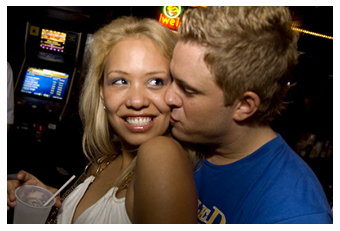

man in black shirt and black pants is sitting on the floor


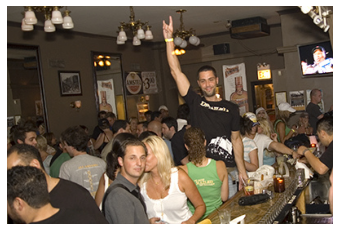

group of people are sitting around table with their hands and one of them is sitting in chair


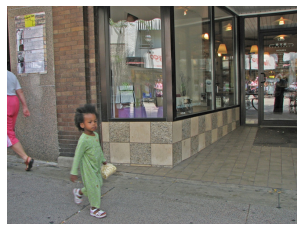

man in black shirt and jeans is standing in front of building


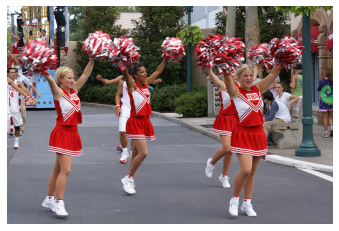

two men in white shirts are walking down the street


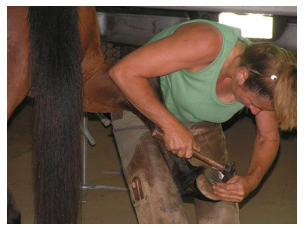

man in blue shirt and blue jeans is sitting on bench


In [94]:
for i in range(len(test)):
    
    img_name = list(encoding_test.keys())[i]
    photo = encoding_test[img_name].reshape((1,2048))

    i = plt.imread(images+"/"+img_name+".jpg")
    plt.imshow(i)
    plt.axis("off")
    plt.show()

    caption = predict_caption(photo)
    print(caption)